## 1. Entropy and Trees

Decision trees work by splitting the sample space into purer segments. The criterion that we will use for splitting is [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) (although you can also use [gini](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)). Entropy is defined as follows:

$$H(C) = - P(c_1)\cdot\log(P(c_1)) - P(c_2)\cdot\log(P(c_2)) -...$$

where $P(c_1)$ is the probability of class $c_1$ in the segment and so on. In a problem with two classes, a pure segment (having either only class $c_1$ instances or class $c_2$) has entropy 0.

<img src="Graphics/Entropy.png" width="50%" align="left">

In this post we will perform the following operations in the context of decision trees:

* Pre-processing, which consists of data cleansing, feature engineering, standarisation (of a subset of features) and dummification of categorical features.
* Predictive modelling: We will start by determining the complexity of the tree to avoid overfitting and high bias. We will use an initial method to narrow the area down and then perform k-fold cross-validation to pick the optimal complexity. Next we will train, test and evaluate the model across most typical metrics, i.e. accuracy, precision, recall, f1-score.
* Visualisation: We will visualise the bias/variance sweetspot, of course the tree itself and the feature space divisions that it creates. Please right click on the images to see them in full size.

Let’s deepdive into the data.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
%matplotlib inline

filename= "data.csv"
raw = pd.read_csv(filename)

## 2. Pre-processing
### 2.1 Cleaning the dataset
First, we drop all lines where the target variable is NaN.

In [3]:
df = raw.dropna()
df.index = range(len(df))
print(df.shape)
df.isnull().values.any()

(25697, 25)


False

Let's start by examining the temporal features. They are relevant as follows: 
* `'Game_date'` may capture performance variability based on the point in a season (e.g. month etc). 
* We break `'game_date'` into month and year. 
* `'Season'` (and the year compnent of `'game_date'`) may capture the effect of ageing in the player's performance ([see Part-1](http://aris.onl/where-amazing-happens/)). 
* Finally, we will use `'time_remaining'` (in seconds) and drop `'seconds'` and `'minutes_remaining'`.

The `'shot_id'` and `'game_id'` may be useful for time series analysis, but for now we can drop them. `'Team_name'` is always LA Lakers, so we can go ahead and drop it from the working dataframe. 

In [4]:
df.loc[:,'month'] = df['game_date'].str[5:7].astype(int)
df.loc[:,'year'] = df['game_date'].str[0:4].astype(int)
df = df.drop('game_date', 1)
df = df.drop('team_name', 1)
df = df.drop('shot_id', 1)
df = df.drop('game_id', 1)
df = df.drop('game_event_id', 1)
df = df.drop('season', 1)
time = Series(df.minutes_remaining*60 + df.seconds_remaining)
df.loc[:,'time_remaining'] = time
df = df.drop('seconds_remaining', 1)
df = df.drop('minutes_remaining', 1)

/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Part of the `'matchup'` information is in `'opponent'`. However, we want to capture the home/away property. We will create a series with 1s where there is *'vs.'* in the field (apparently corresponding to home games) and 0s elsewhere (*'@'* apparently corresponding to away games). I will then drop the `'matchup'` and append the binary series:

In [5]:
home_series = Series([1 if 'vs.' in x else 0 for x in df['matchup']])
home = home_series.to_frame()
df['home'] = home
df = df.drop('matchup', 1)

Now, there is a question pending from [Part-1](http://aris.onl/where-amazing-happens/): Why do we have `'loc_x'`, `'loc_y'` and `'lon'`, `'lat'` in the dataset? We will now check whether they are redundant, "mirrored" data as we suspect from the visulisations of Part-1. A simple way to do this, is to compute the correlations between the variables `'loc_x'` and `'lon'`, and `'loc_y'` and `'lat'` respectively.

In [6]:
A= df[['lon', 'lat', 'loc_x', 'loc_y']].as_matrix()
print(np.corrcoef(A[:,0], A[:,2]))
print(np.corrcoef(A[:,1], A[:,3]))

[[1. 1.]
 [1. 1.]]
[[ 1. -1.]
 [-1.  1.]]


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Evidently the variables are pairwise correlated 100% and thus one of the two pairs is redundant. [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) provides with a particularly convenient pairwise visualisation of features. We can use it to confirm the above visually.

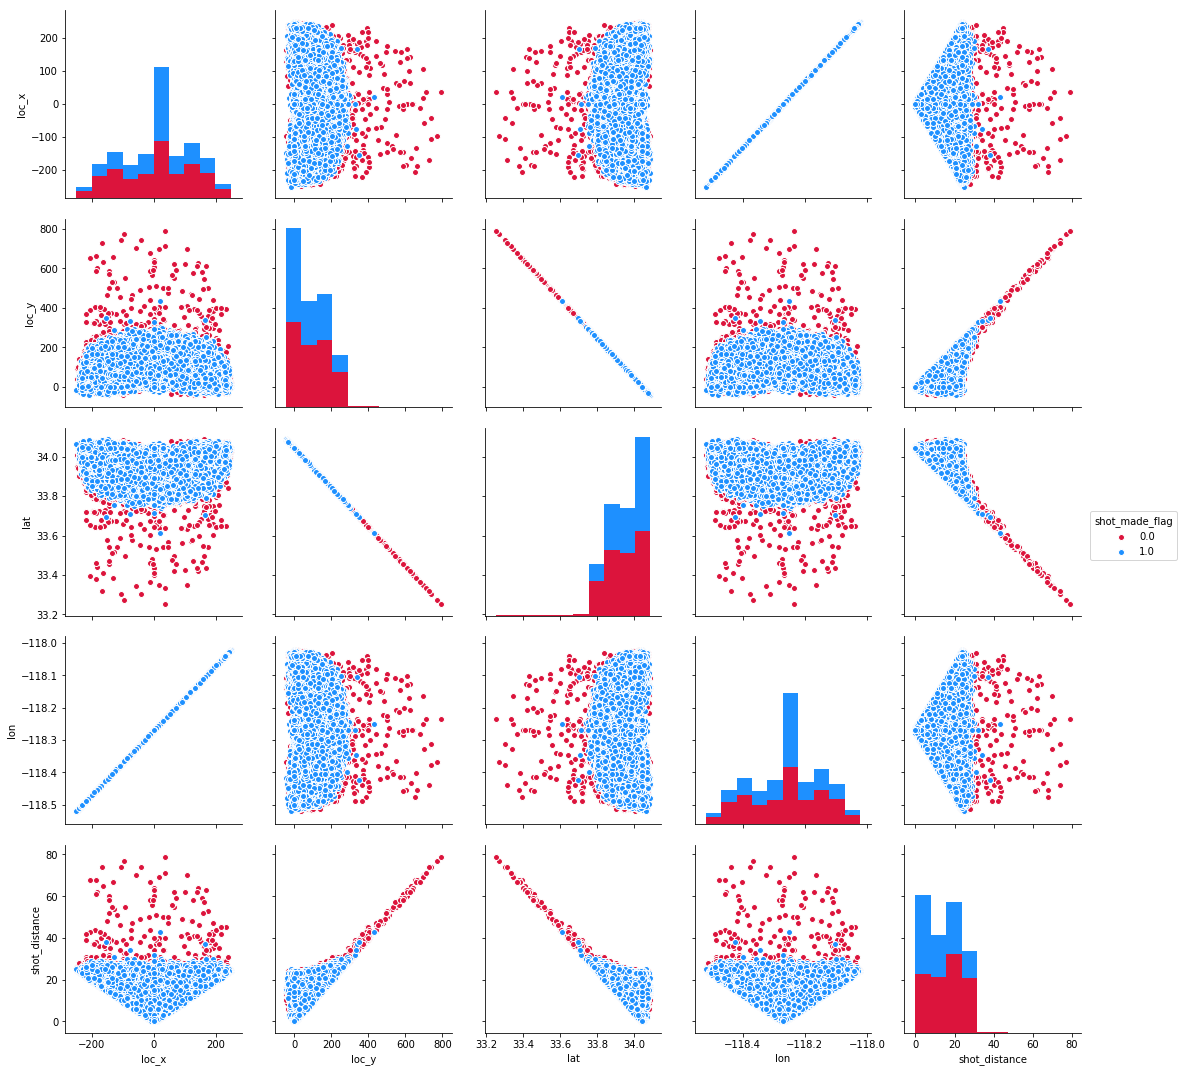

In [7]:
import seaborn as sns
pal = ['Crimson', 'Dodgerblue']
sns.pairplot(df, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3, palette = pal)
plt.show()

Once again, evidently, `'loc_x'` contains the same information as `'lon'` and `'loc_y'` as `'lat'`. We will drop `'lon'` and `'lat'` and check the schema of the dataset before going further.

In [8]:
df = df.drop('lon', 1)
df = df.drop('lat', 1)
df.info()
df.isnull().values.any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 0 to 25696
Data columns (total 18 columns):
action_type           25697 non-null object
combined_shot_type    25697 non-null object
loc_x                 25697 non-null int64
loc_y                 25697 non-null int64
period                25697 non-null int64
playoffs              25697 non-null int64
shot_distance         25697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             25697 non-null object
shot_zone_area        25697 non-null object
shot_zone_basic       25697 non-null object
shot_zone_range       25697 non-null object
team_id               25697 non-null int64
opponent              25697 non-null object
month                 25697 non-null int64
year                  25697 non-null int64
time_remaining        25697 non-null int64
home                  25697 non-null int64
dtypes: float64(1), int64(10), object(7)
memory usage: 5.0+ MB


False

**Good Data Science Note:** Strictly speaking, we should only draw these insights by looking into the training set, not the entire set. By looking into the entire set we are slightly "cheating".  

In fact `'shot distance'` and an `angle` feature are sufficient to represent the spatial properties of a shot. The angle feature is captured by one of the two pairs of coordinates; The player may shoot better from certain angles, may be better shooting with one of two hands etc. Of course, retaining the coordinates and the distance features induces redundancy, but entropy based algorithms have an inherent feature selection property.

### 2.2 Splitting to training and testing set

At this stage, before performing further pre-processing it is better to split the dataset into training and test subsets, in order to avoid information "leaking" into our training set (which in the real world is completely unknown). 

**Good Data Science Note:** The pre-processing to be made on the training set, will be applied to the test set as well but separately.

We will now isolate the target variable vector from the features and split the dataset to 80% training and 20% test set.

In [9]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

y = np.array(df['shot_made_flag']).astype(int)
X = df.drop('shot_made_flag', 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


For the purposes of a tree classifier, features standarisation is not required. This is because trees do not work with any notion of distance, rather with class purity. In addition, we chose a tree classifier as our first model because of their interpretability and feature standarisation would compromise the model's interpretability. 

For the purposes of creating an angle feature though we will standarise `'loc_x'` and `'loc_y'`, to avoid zero values that may result in divisions by zero. With standarisation, the data are re-distributed around a mean of zero in one standard deviation distance. 

**Good Data Science Note:** Once again, this processing must be done in training and testing separately.

**Technical Note:** Scikit's `StandardScaler` provides with the facilities to transform training and testing consistently.

In [10]:
from sklearn import preprocessing

A = X_train[['loc_x', 'loc_y']].copy()

scaler = preprocessing.StandardScaler().fit(A)
A_st = scaler.transform(A)

print(A_st.mean(axis=0), A_st.std(axis=0)) #Note the mean of zero and std of 1 for the two columns

X_train.loc[:, 'angle'] = A_st[:,0]/A_st[:,1]

(array([3.87122568e-17, 3.45645150e-17]), array([1., 1.]))


Next, we apply the same transformation to the test set, by using the same `StandardScaler` object.

In [11]:
B = X_test[['loc_x', 'loc_y']]
B_st = scaler.transform(B)
X_test.loc[:,'angle'] = B_st[:,0]/B_st[:,1]

We can now drop `'loc_x'`, `'loc_y'` from both subsets.

In [12]:
X_test = X_test.drop('loc_x', 1)
X_test = X_test.drop('loc_y', 1)
X_train = X_train.drop('loc_x', 1)
X_train = X_train.drop('loc_y', 1)

X_test.info()
X_test.isnull().values.any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5140 entries, 10177 to 16220
Data columns (total 16 columns):
action_type           5140 non-null object
combined_shot_type    5140 non-null object
period                5140 non-null int64
playoffs              5140 non-null int64
shot_distance         5140 non-null int64
shot_type             5140 non-null object
shot_zone_area        5140 non-null object
shot_zone_basic       5140 non-null object
shot_zone_range       5140 non-null object
team_id               5140 non-null int64
opponent              5140 non-null object
month                 5140 non-null int64
year                  5140 non-null int64
time_remaining        5140 non-null int64
home                  5140 non-null int64
angle                 5140 non-null float64
dtypes: float64(1), int64(8), object(7)
memory usage: 682.7+ KB


False

### 2.3 Categorical features

In order to use Scikit's classifiers, we need to convert the categorical fields. We can do this with Pandas' `get_dummies()`.

**Technical note:** Alternatively Scikit's `OneHotEncoder` or `LabelBinarizer` can be used. 

Let's see how the Pandas method works. We will first get the list of all categorical columns (they are of type object). We can do this with `select_dtypes()`.

In [13]:
cat = df.select_dtypes([object]).columns
cat

Index([u'action_type', u'combined_shot_type', u'shot_type', u'shot_zone_area',
       u'shot_zone_basic', u'shot_zone_range', u'opponent'],
      dtype='object')

What is interesting here is that in the general case, as mentioned before, we should not look into the test set at all when pre-processing. Thus:

1. Encoding the categorical data should be done based on the training set. At this point, the schema of the training set is finalised.
2. Then separately, like we did not know anything about it before, we should encode the categorical data in the test set.
3. With Pandas' `setdiff1d()` we can determine then which dummified columns are missing from the test set compared to the training set and add them with 0 values across all rows. 
4. Finally we will select from the training set the columns that are in the test set, in that same order.

In [14]:
X_train = pd.get_dummies(X_train)

X_test = pd.get_dummies(X_test)

#Get the columns that are in training but not in test
not_in_test = np.setdiff1d(X_train.columns, X_test.columns)
print(not_in_test)

not_in_train = np.setdiff1d(X_test.columns, X_train.columns)
print(not_in_train)

for c in not_in_test: #Add these columns to test, setting them to zero 
    X_test[c] = 0

X_test = X_test[X_train.columns] #Make test be of the same schema as training

['action_type_Cutting Layup Shot' 'action_type_Driving Bank shot'
 'action_type_Driving Floating Bank Jump Shot'
 'action_type_Putback Dunk Shot' 'action_type_Putback Slam Dunk Shot'
 'action_type_Running Finger Roll Shot'
 'action_type_Running Slam Dunk Shot' 'action_type_Tip Layup Shot'
 'action_type_Turnaround Finger Roll Shot']
['action_type_Running Tip Shot']


## 3. Predictive Modelling

### 3.1 High bias vs high variance: the sweetspot

We will now try to see what is a reasonable complexity for our model. A complex model overfits while a simple model is not predictive; 

What is the sweetspot here? We will train tree classifiers of various complexities and visualise their performance on the testing and training set. 

To do so, we will use the `min_samples_leaf` parameter of `DecisionTreeClassifier` which controls the minimum number of samples present at each leaf. The smaller this number is, *the more complex* is the corresponding model. For decision trees, we use balanced sampling to prevent bias for the dominant class.

((5140, 122), (20557, 122), (5140,), (20557,))


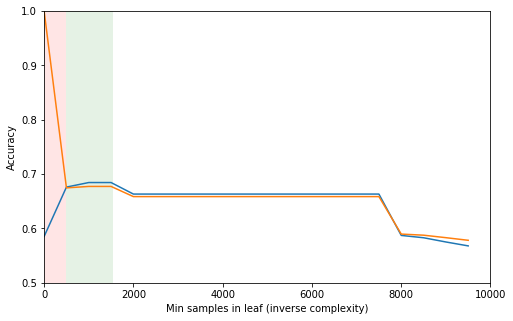

In [15]:
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics

r = np.arange(1, 10000, 500)
a=[]
b=[]

print(X_test.shape, X_train.shape, y_test.shape, y_train.shape)


for i in r:
    clf = tree.DecisionTreeClassifier(min_samples_leaf=i, class_weight='balanced')
    clf = clf.fit(X_train, y_train)
    a.append(clf.score(X_test, y_test))
    b.append(clf.score(X_train, y_train)) #This is done solely for visualising the overfitting effect, evaluating against training data is not part of the analysis
    
plt.figure(figsize=(8, 5))
plt.plot(r, a)
plt.plot(r, b)

#Retroactively marked for visualisation purposes:
plt.axvspan(0, 500, color='r', alpha=0.1, lw=0) 
plt.axvspan(500, 1550, color='g', alpha=0.1, lw=0)
#---

plt.xlim(0, 10000)
plt.ylim(0.5,1)
plt.xlabel('Min samples in leaf (inverse complexity)')
plt.ylabel('Accuracy')
plt.show()

**Good Data Science Note:** In reality you should never evaluate the performance of a model on training data. Here, it is not part of the "real "analysis", it is only done for demonstrating the effect of overfitting and how accuracy varies vs. the model's complexity in relation with overfitting. See below.

* The green line represents performance on the training set and the blue on the testing set. Note that for small numbers of samples in each leaf (high complexity), the model performs very well on the training set and very poorly on the testing set (red area). This is indicative of overfitting. 
* At some point, the two lines converge and the sweetspot seems to be in the area of 500 to 1500 samples in each leaf (green area). 
* Then performance diminishes as the model becomes simplistic (high bias). 

This is the expected behaviour. This rough process is mostly for instructional purposes, but it also helps narrowing down an area of reasonable complexity, in which we can then perform cross-validation, a more expensive and accurate process, in order to pick an optimal value.

### 3.2 K-fold cross-validation

We will use k-fold cross-validation (10 folds) in the area of 250 to 5000 minimum leaf samples value, in order to pick an exact value for use for our model. We will get the mean accuracy and variance of each cross-validation run.

In [16]:
r = np.arange(250, 5000, 250)
r

array([ 250,  500,  750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750,
       3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750])

We will use $F_1$ score to evaluate the models.

**Good Data Science Note:** $F_1$ is prefered over accuracy as a model evaluation metric. Accuracy is not informative of false positive and negative rates which may not worth equal for particular applications and it may be misleading in case of very unbalanced classes (not the case here). 

**Technical Note:** If despite that you want to use accuracy, declare it so in the `scoring` parameter of `cross_val_score`. Scikit learn provides with [an array of alternative metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).

In [17]:
scores = []
for i in r:
    clf = tree.DecisionTreeClassifier(min_samples_leaf=i, class_weight='balanced')
    m = cross_validation.cross_val_score(clf, X_train, y_train, cv=10, scoring='f1')
    scores.append((i, m.mean(), m.var()))
scores

[(250, 0.5788825532605031, 0.00013057255272177034),
 (500, 0.5680530568311328, 0.00013842548983955433),
 (750, 0.5662639042922152, 0.00011669269414323673),
 (1000, 0.5656968358283473, 9.16357776945175e-05),
 (1250, 0.5656968358283473, 9.16357776945175e-05),
 (1500, 0.5656968358283473, 9.16357776945175e-05),
 (1750, 0.5876398800941247, 6.413537266748798e-05),
 (2000, 0.5876398800941247, 6.413537266748798e-05),
 (2250, 0.5876398800941247, 6.413537266748798e-05),
 (2500, 0.5876398800941247, 6.413537266748798e-05),
 (2750, 0.5876398800941247, 6.413537266748798e-05),
 (3000, 0.5876398800941247, 6.413537266748798e-05),
 (3250, 0.5876398800941247, 6.413537266748798e-05),
 (3500, 0.5876398800941247, 6.413537266748798e-05),
 (3750, 0.5876398800941247, 6.413537266748798e-05),
 (4000, 0.5876398800941247, 6.413537266748798e-05),
 (4250, 0.5876398800941247, 6.413537266748798e-05),
 (4500, 0.5876398800941247, 6.413537266748798e-05),
 (4750, 0.5876398800941247, 6.413537266748798e-05)]

### 3.3 Model and visualisation

The minimum number of 1750 samples maximises accuracy and $F_1$. We will now train a Decision Tree with this value. Once more, sampling should be balanced, and the criterion will be entropy (alternatively you can use gini).

In [18]:
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1750, class_weight='balanced')
clf = clf.fit(X_train, y_train)

We will now visualise our decision tree model. In the following graph, blue signifies scored shot prediction and pink represents a missed shot preditcion. Lower entropy (corresponding to higher purity) is represented with darker colors.

In [19]:
from sklearn.externals.six import StringIO
with open("kobe3.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f, feature_names=X_train.columns, class_names=True, filled=True, rounded=True, special_characters=True) 

<img src="Graphics/kobetree.png" width="100%" align="left">

Note that the tree is rooted at `'action type'` (`jump shot`). If you go [back to part-1](http://aris.onl/where-amazing-happens/) of this analysis (previous post, Tableau graphs 4 and 5), you will notice that we were expecting this feature to make it into the predictive model because the target variable varied a lot depending on it. 

Also, note that jump-shot is the dominant type of action. These two combined means that it creates divisions that maximise purity, so it is natural to be the first predictive feature that the model picks up. Single-feature trees (aka decision stumps) are often used as baseline classifiers, `'action type jump shot'` would be the feature for a stump.

For similar reasons, `'shot distance'` and `'season'` (`'year'` here) was also expected to make it high in the model. On the other hand, `'time remaining'` was not that apparently pedictive from the start. 

It is interesting to see how the tree divides the feature space. A typical visualisation is pairwise feature comparison. In our case, we have many categorical and binary features and that does not help visualising, so we will pick two significant numerical features, `'time_remaining'` and `'shot_distance'` and compare how the model complexity affects the areas that the tree creates.

For visualisation purposes:
* We will train a tree classifier for various model complexities like before (more particularly minimum 250-1750 samples at each leaf), only this time with these two features only. 
* We will plot the predicted areas with a contour: In the blue areas, the tree predicts that shot will fail, while in the yellow ones that the shot will succeed. 
* We will also plot the test dataset on top: Red points are actual missed shots and black ones are scored. 
* The subplots represent gradually simpler models. Note how the boundary becomes gradually simpler. For small minimum numbers per leaf, the tree overfits.

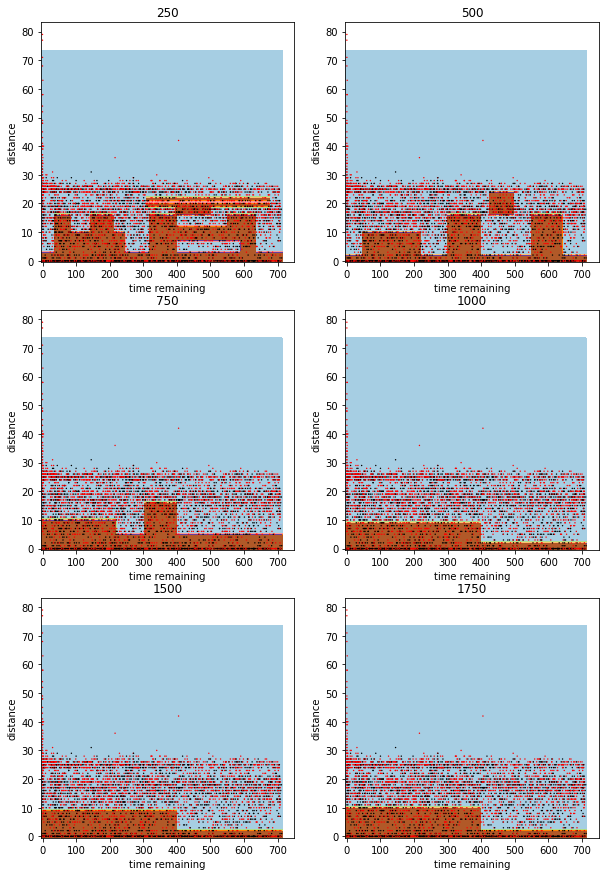

In [20]:
Xviztr = DataFrame()
Xviztst = DataFrame()
Xviztr['time_remaining'] = X_train['time_remaining']
Xviztr['shot_distance'] = X_train['shot_distance']
Xviztst['time_remaining'] = X_test['time_remaining']
Xviztst['shot_distance'] = X_test['shot_distance']

t_min, t_max = -5, 714 
d_min, d_max = -0.5, 74
tt, dd = np.meshgrid(np.arange(t_min, t_max, 1), np.arange(d_min, d_max, 1))

colors = np.where(y_test==1, "black", "red");        

def classgraph(n, i):
    sp = plt.subplot(3, 2, i)
    sp.set_title(n)
    plt.xlabel('time remaining')
    plt.ylabel('distance')
    clfviz = tree.DecisionTreeClassifier(min_samples_leaf=n, class_weight='balanced') 
    clfviz.fit(Xviztr, y_train)
    Z = clfviz.predict(zip(tt.ravel(), dd.ravel()))
    Z = Z.reshape(tt.shape)
    cs = plt.contourf(tt, dd, Z, cmap=plt.cm.Paired)
    plt.scatter(Xviztst['time_remaining'], Xviztst['shot_distance'], c=colors, s=2, alpha=1, lw=0)

leaf = [250, 500, 750, 1000, 1500, 1750]
plt.figure(figsize=(10,15))   
for k in leaf:
    classgraph(k, leaf.index(k)+1)

### 3.4 Model evaluation

In [21]:
y_predict = clf.predict(X_test)
y_predict.shape

(5140,)

In [22]:
metrics.accuracy_score(y_test, y_predict, normalize=True)

0.6632295719844358

Does this accuracy score beat the baseline majority classifier (a "classifier" that always predicts the dominant class), and if so by how much?

In [23]:
no = np.where(y_test == 0)[0].size
yes = np.where(y_test == 1)[0].size
print (no, yes)

(2848, 2292)


In [24]:
from __future__ import division
no/(no+yes)

0.5540856031128405

Thus the decision tree is predictive with an accuracy ~0.68, a significant improvement over the baseline majority classifier which has an accuracy of 0.55. Let's go ahead and inspect the confusion matrix as well as the precision, recall and $F_1$ scores.

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
cm

array([[2123,  725],
       [1006, 1286]])

Rows are true values, columns are predicted values and classes appear in ranked order (so 0, 1). According to this, we get a high number of false negatives (1783). For transparency, we can plot the confusion matrix.

Text(15,0.5,'Real class')

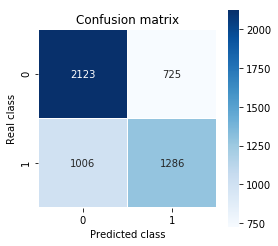

In [26]:
plt.figure(figsize=(4,4))
plt.title('Confusion matrix')
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', square=True, linewidths=.5)
ax.set_xlabel('Predicted class')
ax.set_ylabel('Real class')

Now let's examine the precision, recall and $F_1$ score:

In [27]:
metrx = {'precision': metrics.precision_score(y_test, y_predict), 
'recall': metrics.recall_score(y_test, y_predict),
'f1': metrics.f1_score(y_test, y_predict)}
print(metrx)

{'recall': 0.5610820244328097, 'precision': 0.6394828443560417, 'f1': 0.5977225191726702}


The high number of false negatives causes a low recall.